In [1]:
%matplotlib inline

import cv2
import numpy as np
import scipy
from scipy.spatial.distance import euclidean
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import glob
from tqdm import tqdm

In [2]:
def fcall(img_nm):
    
    #대상 이미지 파일의 확장자를 확인할 것.
    filename = img_nm+'.png'

    # Load the image and convert it to grayscale:
    image = cv2.imread(filename)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #cv2.THRESH_BINARY 인지 cv2.THRESH_BINARY_INV 꼭 확인할것!
    ret, thresh = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY_INV)
    
    return thresh

In [3]:
def find_a_contour(thresh):
    contours, hierarchy = cv2.findContours(
        thresh, 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_NONE)
    ncnt = len(contours[:]) #ncnt = number of contour lines
    chk = 0 #chk은 w번째 경계면을 이루는 좌표의 갯수이다
    set = 0 #set이 내가 찾고 싶은 경계면의 번호이다
    for w in range(ncnt):
       if chk < len(contours[w]):
            chk = len(contours[w])
            set = w
    # 찾은 contour 좌표를 contour_array에 저장한다
    contour_array=contours[set][:,0,:]

    # 폐합된(closed) 다각형(polygon) 좌표군을 생성한다.
    polyg = np.append(contour_array, contour_array[0,:].reshape(1,2), axis=0)
    
    # Equivalent diameter를 구한다.
    area = cv2.contourArea(contours[set])
    equi_diameter = np.sqrt(4*area/np.pi)
    
    return contour_array, polyg, equi_diameter


In [4]:
def find_eqdpt(polyg, numOfSegments):

    #Find Contour Perimeter
    perimeter = cv2.arcLength(polyg,True)

    #Find Segment length
    SegLength = perimeter/numOfSegments

    lastpt = polyg[0:1] #제일 첫 point를 last point로 설정
    eqdpt  = polyg[0:1]
    polyIdx = 0
    lenToGo = SegLength

    while len(eqdpt)<numOfSegments:
        lenOnPolyline = np.linalg.norm(polyg[polyIdx+1]-lastpt)
        if lenOnPolyline > lenToGo:
            unitv = polyg[polyIdx+1]-lastpt
            unitv = unitv / np.linalg.norm(unitv)       
            lastpt = unitv*lenToGo + lastpt
            eqdpt = np.append(eqdpt,lastpt.reshape(1,2),axis=0)
            lenToGo = SegLength
        else:
            lenToGo = lenToGo - lenOnPolyline
            polyIdx += 1
            lastpt = polyg[polyIdx]    
    
    return eqdpt

In [5]:
def trans_eqdpt(eqdpt, polyg, contour_array):
    # Find Centroid
    M = cv2.moments(contour_array)
    cX = np.int32(M["m10"]/M["m00"])
    cY = np.int32(M["m01"]/M["m00"])

    # Translate Contour points
    centroid = np.empty(contour_array.shape)
    centroid[:,0] = cX
    centroid[:,1] = cY
    contour_array = contour_array - centroid

    centroid = np.empty(polyg.shape)
    centroid[:,0] = cX
    centroid[:,1] = cY
    polyg = polyg - centroid
        
    centroid = np.empty(eqdpt.shape)
    centroid[:,0] = cX
    centroid[:,1] = cY
    
    eqdpt = eqdpt - centroid
    
    return eqdpt, polyg, contour_array

In [6]:
def find_FD(eqdpt,sig_num):

    # 푸리에 변환에 사용할 절점 g의 갯수 = M
    M = len(eqdpt)    
    
    #2차원 Fourier 변환을 위한 준비(복소수형태로 좌표를 변환시킴) --> fft 변환 --> fourier_result에 coef값 저장
    eqdpt_complex = np.empty(eqdpt.shape[:-1],dtype=complex)
    eqdpt_complex.real = eqdpt[:,0]
    eqdpt_complex.imag = eqdpt[:,1]

    fft_result = np.fft.fft(eqdpt_complex)  # np.fft.fft로 구한 coef값은 1/M되지 않았다.
    fft_result = fft_result/M  # 1/M로 나눠주었다.
    fftshifted = np.fft.fftshift(fft_result)  # fftshift가 zero-freq를 중앙으로 위치시킨다.
    
    #sig_num 가 몇개를 추출할지 결정 (pair의 갯수임)
    if (len(fftshifted) % 2) == 0:
        center_index = len(fftshifted)/2
    else:
        center_index = (len(fftshifted)+1)/2
    start = np.int32(center_index - sig_num)
    end   = np.int32(center_index + sig_num) +1

    #print('center,start,end=',center_index,start,end)
    
    G = fftshifted[start:end]  #start와 end 사이의 중앙값이 가장 큰 coef를 가진다.
    
    # Calculate Magnitude of Fourier Descriptor Coefficients
    G_real = G.real
    G_imag = G.imag
    G_mag  = np.sqrt(G_real**2+G_imag**2)
    
    return G_mag, G_real, G_imag, fft_result, fftshifted

In [7]:
def dcfft(img_nm,numOfseg,sig_num):

    thresh = fcall(img_nm)
    
    #입자 이미지의 경계면 좌표를 찾는다.
    contour_array, polyg, eqdia = find_a_contour(thresh)
    
    #앞서 얻은 경계면 좌표 간격은 일정하지 않다. 이를 일정한 간격이 되도록 좌표를 다시 찾는다.
    #numOfSegments = by input param   #등간격 세그먼트의 숫자를 지정한다. 2^n 으로 지정
    eqdpt = find_eqdpt(polyg, numOfseg)
    
    #좌표군들의 도심이 원점이 되도록 이동(translation)시킨다.
    eqdpt, polyg, contour_array = trans_eqdpt(eqdpt, polyg, contour_array)

    #FFT를 실시하여 Fourier Descriptor를 찾는다.
    #sig_num = by input param         #중심을 기준으로 추출할 FD의 갯수를 정한다.
    idx = pd.DataFrame({'idx':np.arange(-sig_num,sig_num+1)})
    
    a,b,c,d,e = find_FD(eqdpt,sig_num)
    
    df1 = pd.DataFrame({'mag':a,'real':b,'imag':c})
    df2 = pd.DataFrame({'fft_result':d,'fftshift_result':e})
    df3 = pd.DataFrame({'x0':eqdpt[:,0],'y0':eqdpt[:,1]})
    
    return df1, df2, df3, eqdia

In [20]:
def fdrecon(N, sig_num, df):
    
    x1 = []
    y1 = []

    for k in np.arange(0, N, 1):
        t = k / N
        x = 0
        y = 0

        for m in np.arange(-sig_num, sig_num + 1):
            phi = 2 * np.pi * m * t
            A = df.loc[m, 'std_real']
            B = df.loc[m, 'std_imag']
            x += A * np.cos(phi) - B * np.sin(phi)
            y += A * np.sin(phi) + B * np.cos(phi)

        x1.append(x)
        y1.append(y)

    # Plotting the contour and filling it
    plt.fill(x1, y1, color='black')

    # Remove the axis and grid lines
    plt.axis('equal')
    plt.axis('off')
    
    plt.title("Standard Figure")
    file_name = "Standard Figure5.png"
    cwd = os.getcwd()
    folder_path = cwd
    save_path = os.path.join(folder_path, file_name)
    fig = plt.gcf()
    fig.savefig(save_path, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

In [21]:
numOfseg = 256   #[중요] 등간격 세그먼트의 숫자를 지정한다. 2^n 으로 지정
sig_num = 20      #[중요] Zero-Freq 중심을 기준으로 아래 위로 추출할 FD의 갯수를 정한다. (Pair의 숫자임)

In [26]:
mylist = [f for f in sorted(glob.glob("processed*.png"))]  #읽어들일 파일의 확장자 확인할것

mag = pd.DataFrame({'idx':np.arange(-sig_num,sig_num+1)})
real = mag
imag = mag

x0 = pd.DataFrame()
y0 = pd.DataFrame()
eqdia = pd.DataFrame()

for img_nm in tqdm(mylist[:]):
    title = img_nm[:-4]
    df1,df2,df3,eqd = dcfft(title,numOfseg,sig_num)
    mag  = pd.concat([mag, df1['mag']],axis=1)
    real = pd.concat([real,df1['real']],axis=1)
    imag = pd.concat([imag,df1['imag']],axis=1)
    x0 = pd.concat([x0,df3['x0']],axis=1)
    y0 = pd.concat([y0,df3['y0']],axis=1)
    d = pd.DataFrame([eqd])
    eqdia = pd.concat([eqdia,d],axis=1)
    
mag = mag.set_index('idx')    
real = real.set_index('idx')
imag = imag.set_index('idx')

mag.columns = mylist
real.columns = mylist
imag.columns = mylist
x0.columns = mylist
y0.columns = mylist
eqdia.columns = mylist

100%|██████████| 5/5 [00:00<00:00, 67.55it/s]


In [27]:
def std_image(mylist):
    
    std_imag = imag.mean(axis='columns')
    std_real = real.mean(axis='columns')
    
    df = pd.DataFrame({'std_imag':std_imag,'std_real':std_real})
    
    return df

In [28]:
def mean_std(df,mag):
    
    df1 = (df.std_imag**2 + df.std_real**2)**0.5
    mags = mag.stack()
    result1 = df1
    result2 = df1
    
    for i in mag.index:
        result1.loc[i] = mags[i].mean()
    print(result1)
    
    for i in mag.index:
        result2.loc[i] = mags[i].std(ddof=0)
    print(result2)

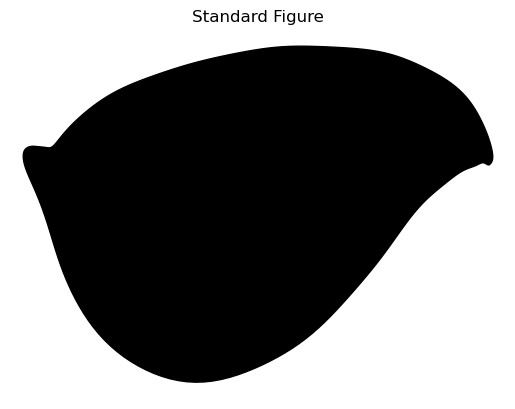

In [29]:
df1 = std_image(mylist)
dfs = (df1.std_imag**2 + df1.std_real**2)**0.5
fdrecon(numOfseg, sig_num, df1)